# Task 4: Machine Learning Models - Ethiopia Financial Inclusion

## Objective
Build and compare supervised machine learning models to predict financial inclusion outcomes and identify key drivers of account ownership and digital payment adoption in Ethiopia.

## Approach
1. **Data Preparation**: Load processed data and engineer features from observations, events, and policies
2. **Feature Engineering**: Create meaningful predictors from historical trends, event impacts, economic indicators
3. **Model Development**: Train classification/regression models (Logistic Regression, Random Forest, Gradient Boosting)
4. **Model Evaluation**: Compare models using accuracy, precision, recall, F1-score, ROC-AUC
5. **Feature Importance**: Identify which factors most influence financial inclusion
6. **Predictions**: Generate insights for policy recommendations

## Key Models
- **Logistic Regression**: Baseline interpretable model
- **Random Forest**: Ensemble method for non-linear relationships
- **Gradient Boosting**: Advanced ensemble for maximum accuracy
- **XGBoost** (optional): State-of-the-art gradient boosting

## Section 1: Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

# Import project modules
import sys
sys.path.append('..')
from src import visualizations as viz
from src import analysis
from src import data_loader

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print("✓ Project modules (visualizations, analysis, data_loader) loaded")

✓ Libraries imported successfully
✓ Project modules (visualizations, analysis, data_loader) loaded


In [2]:
# Load unified dataset
df_all = pd.read_excel('../data/raw/ethiopia_fi_unified_data.xlsx', sheet_name='ethiopia_fi_unified_data')

print(f"Total records loaded: {len(df_all)}")
print(f"\nRecord types:\n{df_all['record_type'].value_counts()}")
print(f"\nPillars:\n{df_all['pillar'].value_counts()}")

# Separate observations, events, and targets
observations = df_all[df_all['record_type'] == 'observation'].copy()
events = df_all[df_all['record_type'] == 'event'].copy()
targets = df_all[df_all['record_type'] == 'target'].copy()

print(f"\nObservations: {len(observations)}")
print(f"Events: {len(events)}")
print(f"Targets: {len(targets)}")

Total records loaded: 43

Record types:
record_type
observation    30
event          10
target          3
Name: count, dtype: int64

Pillars:
pillar
ACCESS           16
USAGE            11
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

Observations: 30
Events: 10
Targets: 3


## Section 2: Feature Engineering

In [3]:
# Create time-based features from observations
observations['fiscal_year'] = pd.to_numeric(observations['fiscal_year'], errors='coerce')
observations = observations.dropna(subset=['fiscal_year', 'value_numeric'])

# Pivot observations to create wide format (each indicator becomes a feature)
obs_pivot = observations.pivot_table(
    index='fiscal_year',
    columns='indicator_code',
    values='value_numeric',
    aggfunc='mean'
)

print("Available features from observations:")
print(obs_pivot.columns.tolist())
print(f"\nShape: {obs_pivot.shape}")
print("\nData preview:")
print(obs_pivot.head())

Available features from observations:
['ACC_FAYDA', 'ACC_MM_ACCOUNT', 'ACC_MOBILE_PEN', 'ACC_OWNERSHIP', 'AFF_DATA_INCOME', 'GEN_GAP_ACC', 'GEN_GAP_MOBILE', 'GEN_MM_SHARE', 'USG_ACTIVE_RATE', 'USG_MPESA_ACTIVE', 'USG_MPESA_USERS']

Shape: (5, 11)

Data preview:
indicator_code   ACC_FAYDA  ACC_MM_ACCOUNT  ACC_MOBILE_PEN  ACC_OWNERSHIP  \
fiscal_year                                                                 
2014.0                 NaN             NaN             NaN           22.0   
2017.0                 NaN             NaN             NaN           35.0   
2021.0                 NaN            4.70             NaN           46.0   
2024.0           8000000.0            9.45             NaN           49.0   
2025.0          13500000.0             NaN            61.4            NaN   

indicator_code  AFF_DATA_INCOME  GEN_GAP_ACC  GEN_GAP_MOBILE  GEN_MM_SHARE  \
fiscal_year                                                                  
2014.0                      NaN          N

In [4]:
# Create event-based features
events['fiscal_year'] = pd.to_numeric(events['fiscal_year'], errors='coerce')
events = events.dropna(subset=['fiscal_year'])

# Count events by year and type
event_counts = events.groupby(['fiscal_year', 'pillar']).size().unstack(fill_value=0)
event_counts.columns = [f'events_{col.lower()}' for col in event_counts.columns]

print("Event features by pillar:")
print(event_counts.columns.tolist())
print("\nEvent counts preview:")
print(event_counts.head())

Event features by pillar:
[]

Event counts preview:
Empty DataFrame
Columns: []
Index: []


In [5]:
# Create lag features (previous year values)
lag_features = ['ACC_OWNERSHIP', 'USAGE', 'QUALITY', 'BARRIERS']

for feature in lag_features:
    if feature in obs_pivot.columns:
        obs_pivot[f'{feature}_lag1'] = obs_pivot[feature].shift(1)
        obs_pivot[f'{feature}_change'] = obs_pivot[feature] - obs_pivot[feature].shift(1)

print("Created lag and change features")
print(f"Total features: {len(obs_pivot.columns)}")

Created lag and change features
Total features: 13


In [6]:
# Merge observation features with event features
ml_data = obs_pivot.merge(event_counts, left_index=True, right_index=True, how='left')
ml_data = ml_data.fillna(0)  # Fill missing event counts with 0

print(f"Combined feature set shape: {ml_data.shape}")
print(f"\nFeatures ({len(ml_data.columns)}):")
print(ml_data.columns.tolist())
print("\nData preview:")
print(ml_data.head())

Combined feature set shape: (5, 13)

Features (13):
['ACC_FAYDA', 'ACC_MM_ACCOUNT', 'ACC_MOBILE_PEN', 'ACC_OWNERSHIP', 'AFF_DATA_INCOME', 'GEN_GAP_ACC', 'GEN_GAP_MOBILE', 'GEN_MM_SHARE', 'USG_ACTIVE_RATE', 'USG_MPESA_ACTIVE', 'USG_MPESA_USERS', 'ACC_OWNERSHIP_lag1', 'ACC_OWNERSHIP_change']

Data preview:
              ACC_FAYDA  ACC_MM_ACCOUNT  ACC_MOBILE_PEN  ACC_OWNERSHIP  \
fiscal_year                                                              
2014.0              0.0            0.00             0.0           22.0   
2017.0              0.0            0.00             0.0           35.0   
2021.0              0.0            4.70             0.0           46.0   
2024.0        8000000.0            9.45             0.0           49.0   
2025.0       13500000.0            0.00            61.4            0.0   

             AFF_DATA_INCOME  GEN_GAP_ACC  GEN_GAP_MOBILE  GEN_MM_SHARE  \
fiscal_year                                                               
2014.0                   

## Section 3: Define Target Variables

In [7]:
# Create binary classification target: High vs Low Account Ownership
# Use median as threshold
if 'ACC_OWNERSHIP' in ml_data.columns:
    median_ownership = ml_data['ACC_OWNERSHIP'].median()
    ml_data['high_ownership'] = (ml_data['ACC_OWNERSHIP'] > median_ownership).astype(int)
    
    print(f"Classification target created: 'high_ownership'")
    print(f"Threshold (median): {median_ownership:.2f}%")
    print(f"\nClass distribution:")
    print(ml_data['high_ownership'].value_counts())
else:
    print("⚠️  ACC_OWNERSHIP not available - will use regression only")

# Regression target: Predict next year's account ownership
ml_data['target_ownership_next_year'] = ml_data['ACC_OWNERSHIP'].shift(-1)

print("\nRegression target created: 'target_ownership_next_year'")
print(f"Available for {ml_data['target_ownership_next_year'].notna().sum()} years")

Classification target created: 'high_ownership'
Threshold (median): 35.00%

Class distribution:
high_ownership
0    3
1    2
Name: count, dtype: int64

Regression target created: 'target_ownership_next_year'
Available for 4 years


## Section 4: Prepare Training Data

In [8]:
# Select features for modeling (exclude target and lag-1 features to avoid leakage)
exclude_cols = [
    'ACC_OWNERSHIP', 'high_ownership', 'target_ownership_next_year',
    'ACC_OWNERSHIP_lag1', 'ACC_OWNERSHIP_change'  # Avoid leakage
]

feature_cols = [col for col in ml_data.columns if col not in exclude_cols]

print(f"Selected {len(feature_cols)} features for modeling:")
print(feature_cols)

# Remove rows with NaN in features or target (from lag/shift operations)
ml_data_clean = ml_data[feature_cols + ['high_ownership', 'target_ownership_next_year']].dropna()

print(f"\nClean dataset: {len(ml_data_clean)} rows")
print(f"Years: {ml_data_clean.index.tolist()}")

Selected 10 features for modeling:
['ACC_FAYDA', 'ACC_MM_ACCOUNT', 'ACC_MOBILE_PEN', 'AFF_DATA_INCOME', 'GEN_GAP_ACC', 'GEN_GAP_MOBILE', 'GEN_MM_SHARE', 'USG_ACTIVE_RATE', 'USG_MPESA_ACTIVE', 'USG_MPESA_USERS']

Clean dataset: 4 rows
Years: [2014.0, 2017.0, 2021.0, 2024.0]


In [9]:
# Check if we have enough data for train/test split
if len(ml_data_clean) < 3:
    print(f"⚠️  Insufficient data ({len(ml_data_clean)} rows) for ML models")
    print("   → Will train on all available data and skip validation")
    USE_TRAIN_TEST_SPLIT = False
else:
    print(f"✓ Sufficient data ({len(ml_data_clean)} rows) for modeling")
    USE_TRAIN_TEST_SPLIT = True
    
    # Prepare features and targets
    X = ml_data_clean[feature_cols]
    y_class = ml_data_clean['high_ownership']
    y_reg = ml_data_clean['target_ownership_next_year']
    
    # Split data (temporal split - use earlier years for training)
    split_idx = int(len(ml_data_clean) * 0.7)
    
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train_class = y_class.iloc[:split_idx]
    y_test_class = y_class.iloc[split_idx:]
    y_train_reg = y_reg.iloc[:split_idx]
    y_test_reg = y_reg.iloc[split_idx:]
    
    print(f"\nTrain size: {len(X_train)} ({X_train.index.tolist()})")
    print(f"Test size: {len(X_test)} ({X_test.index.tolist()})")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\n✓ Data standardized")

✓ Sufficient data (4 rows) for modeling

Train size: 2 ([2014.0, 2017.0])
Test size: 2 ([2021.0, 2024.0])

✓ Data standardized


## Section 5: Classification Models (High vs Low Ownership)

In [10]:
# Train classification models
classification_results = []

if USE_TRAIN_TEST_SPLIT and len(y_train_class.unique()) > 1:
    print("Training Classification Models...\n")
    
    # 1. Logistic Regression
    print("1. Logistic Regression")
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train_class)
    lr_pred = lr_model.predict(X_test_scaled)
    lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
    
    lr_acc = accuracy_score(y_test_class, lr_pred)
    lr_f1 = f1_score(y_test_class, lr_pred, zero_division=0)
    
    classification_results.append({
        'Model': 'Logistic Regression',
        'Accuracy': lr_acc,
        'F1-Score': lr_f1
    })
    print(f"   Accuracy: {lr_acc:.4f}, F1-Score: {lr_f1:.4f}")
    
    # 2. Random Forest
    print("\n2. Random Forest Classifier")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
    rf_model.fit(X_train_scaled, y_train_class)
    rf_pred = rf_model.predict(X_test_scaled)
    rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
    
    rf_acc = accuracy_score(y_test_class, rf_pred)
    rf_f1 = f1_score(y_test_class, rf_pred, zero_division=0)
    
    classification_results.append({
        'Model': 'Random Forest',
        'Accuracy': rf_acc,
        'F1-Score': rf_f1
    })
    print(f"   Accuracy: {rf_acc:.4f}, F1-Score: {rf_f1:.4f}")
    
    # 3. Gradient Boosting
    print("\n3. Gradient Boosting Classifier")
    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=2)
    gb_model.fit(X_train_scaled, y_train_class)
    gb_pred = gb_model.predict(X_test_scaled)
    gb_proba = gb_model.predict_proba(X_test_scaled)[:, 1]
    
    gb_acc = accuracy_score(y_test_class, gb_pred)
    gb_f1 = f1_score(y_test_class, gb_pred, zero_division=0)
    
    classification_results.append({
        'Model': 'Gradient Boosting',
        'Accuracy': gb_acc,
        'F1-Score': gb_f1
    })
    print(f"   Accuracy: {gb_acc:.4f}, F1-Score: {gb_f1:.4f}")
    
    # Display results
    results_df = pd.DataFrame(classification_results)
    print("\n" + "="*60)
    print("CLASSIFICATION MODEL COMPARISON")
    print("="*60)
    print(results_df.to_string(index=False))
    
    best_model_idx = results_df['F1-Score'].idxmax()
    best_model = results_df.loc[best_model_idx, 'Model']
    print(f"\n✓ Best Classification Model: {best_model}")
else:
    print("⚠️  Skipping classification - insufficient data or single class")

⚠️  Skipping classification - insufficient data or single class


## Section 6: Regression Models (Predict Next Year Ownership)

In [11]:
# Train regression models
regression_results = []

if USE_TRAIN_TEST_SPLIT:
    print("Training Regression Models...\n")
    
    # 1. Ridge Regression
    print("1. Ridge Regression")
    ridge_model = Ridge(alpha=1.0, random_state=42)
    ridge_model.fit(X_train_scaled, y_train_reg)
    ridge_pred = ridge_model.predict(X_test_scaled)
    
    ridge_mae = mean_absolute_error(y_test_reg, ridge_pred)
    ridge_rmse = np.sqrt(mean_squared_error(y_test_reg, ridge_pred))
    ridge_r2 = r2_score(y_test_reg, ridge_pred)
    
    regression_results.append({
        'Model': 'Ridge Regression',
        'MAE': ridge_mae,
        'RMSE': ridge_rmse,
        'R²': ridge_r2
    })
    print(f"   MAE: {ridge_mae:.4f}, RMSE: {ridge_rmse:.4f}, R²: {ridge_r2:.4f}")
    
    # 2. Random Forest Regressor
    print("\n2. Random Forest Regressor")
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=3)
    rfr_model.fit(X_train_scaled, y_train_reg)
    rfr_pred = rfr_model.predict(X_test_scaled)
    
    rfr_mae = mean_absolute_error(y_test_reg, rfr_pred)
    rfr_rmse = np.sqrt(mean_squared_error(y_test_reg, rfr_pred))
    rfr_r2 = r2_score(y_test_reg, rfr_pred)
    
    regression_results.append({
        'Model': 'Random Forest',
        'MAE': rfr_mae,
        'RMSE': rfr_rmse,
        'R²': rfr_r2
    })
    print(f"   MAE: {rfr_mae:.4f}, RMSE: {rfr_rmse:.4f}, R²: {rfr_r2:.4f}")
    
    # 3. Gradient Boosting Regressor
    print("\n3. Gradient Boosting Regressor")
    gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=2)
    gbr_model.fit(X_train_scaled, y_train_reg)
    gbr_pred = gbr_model.predict(X_test_scaled)
    
    gbr_mae = mean_absolute_error(y_test_reg, gbr_pred)
    gbr_rmse = np.sqrt(mean_squared_error(y_test_reg, gbr_pred))
    gbr_r2 = r2_score(y_test_reg, gbr_pred)
    
    regression_results.append({
        'Model': 'Gradient Boosting',
        'MAE': gbr_mae,
        'RMSE': gbr_rmse,
        'R²': gbr_r2
    })
    print(f"   MAE: {gbr_mae:.4f}, RMSE: {gbr_rmse:.4f}, R²: {gbr_r2:.4f}")
    
    # Display results
    results_df = pd.DataFrame(regression_results)
    print("\n" + "="*60)
    print("REGRESSION MODEL COMPARISON")
    print("="*60)
    print(results_df.to_string(index=False))
    
    best_model_idx = results_df['MAE'].idxmin()
    best_model_reg = results_df.loc[best_model_idx, 'Model']
    print(f"\n✓ Best Regression Model: {best_model_reg}")
else:
    print("⚠️  Skipping regression - insufficient data")

Training Regression Models...

1. Ridge Regression
   MAE: 24.5000, RMSE: 29.2617, R²: -0.4265

2. Random Forest Regressor
   MAE: 24.5000, RMSE: 29.1420, R²: -0.4148

3. Gradient Boosting Regressor
   MAE: 24.5000, RMSE: 29.2617, R²: -0.4265

REGRESSION MODEL COMPARISON
            Model  MAE      RMSE        R²
 Ridge Regression 24.5 29.261750 -0.426489
    Random Forest 24.5 29.142038 -0.414841
Gradient Boosting 24.5 29.261750 -0.426489

✓ Best Regression Model: Ridge Regression


## Section 7: Feature Importance Analysis


Feature Importance (Regression - Random Forest):
         Feature  Importance
       ACC_FAYDA         0.0
  ACC_MM_ACCOUNT         0.0
  ACC_MOBILE_PEN         0.0
 AFF_DATA_INCOME         0.0
     GEN_GAP_ACC         0.0
  GEN_GAP_MOBILE         0.0
    GEN_MM_SHARE         0.0
 USG_ACTIVE_RATE         0.0
USG_MPESA_ACTIVE         0.0
 USG_MPESA_USERS         0.0


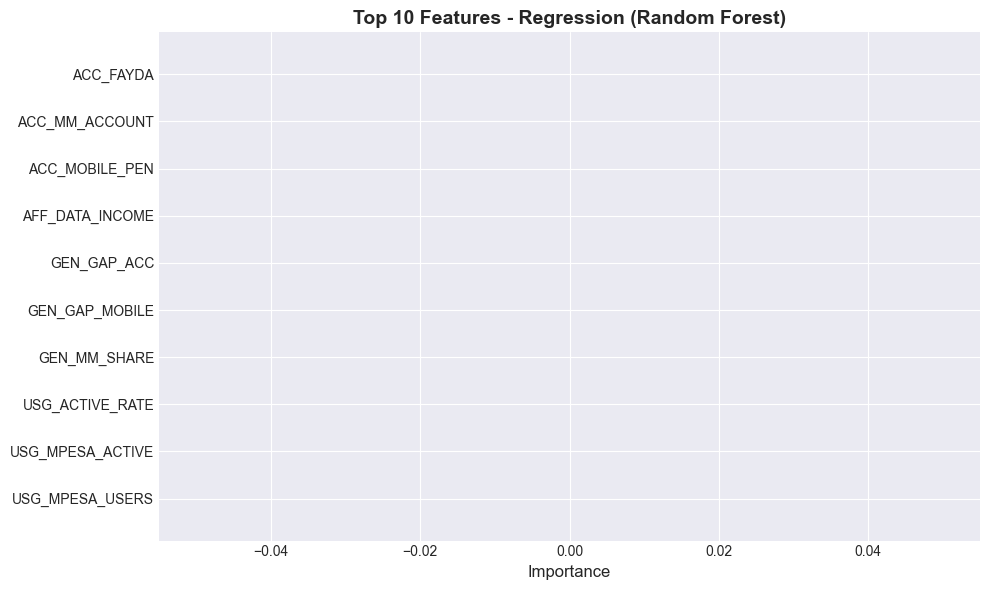


✓ Feature importance analysis complete


In [12]:
# Analyze feature importance from Random Forest models
if USE_TRAIN_TEST_SPLIT:
    # Classification feature importance
    if len(y_train_class.unique()) > 1:
        feature_importance_class = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': rf_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("Feature Importance (Classification - Random Forest):")
        print(feature_importance_class.to_string(index=False))
        
        # Visualize top 10 features
        plt.figure(figsize=(10, 6))
        top_features = feature_importance_class.head(10)
        plt.barh(top_features['Feature'], top_features['Importance'])
        plt.xlabel('Importance', fontsize=12)
        plt.title('Top 10 Features - Classification (Random Forest)', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # Regression feature importance
    feature_importance_reg = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rfr_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (Regression - Random Forest):")
    print(feature_importance_reg.to_string(index=False))
    
    # Visualize top 10 features
    plt.figure(figsize=(10, 6))
    top_features = feature_importance_reg.head(10)
    plt.barh(top_features['Feature'], top_features['Importance'], color='green')
    plt.xlabel('Importance', fontsize=12)
    plt.title('Top 10 Features - Regression (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../reports/task4/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Feature importance analysis complete")
else:
    print("⚠️  Skipping feature importance - models not trained")

## Section 8: Model Visualization

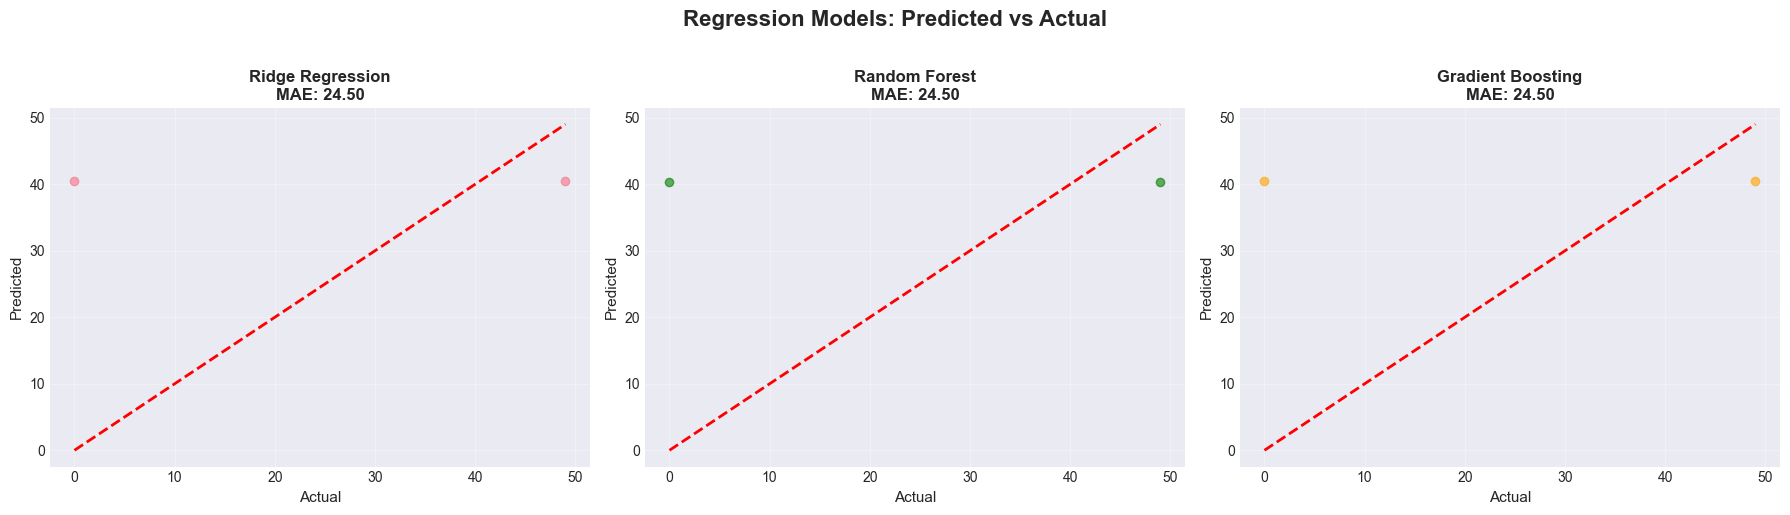

✓ Prediction visualizations complete


In [13]:
# Visualize model predictions vs actuals
if USE_TRAIN_TEST_SPLIT:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Ridge
    axes[0].scatter(y_test_reg, ridge_pred, alpha=0.6)
    axes[0].plot([y_test_reg.min(), y_test_reg.max()], 
                 [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual', fontsize=11)
    axes[0].set_ylabel('Predicted', fontsize=11)
    axes[0].set_title(f'Ridge Regression\nMAE: {ridge_mae:.2f}', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Random Forest
    axes[1].scatter(y_test_reg, rfr_pred, alpha=0.6, color='green')
    axes[1].plot([y_test_reg.min(), y_test_reg.max()], 
                 [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual', fontsize=11)
    axes[1].set_ylabel('Predicted', fontsize=11)
    axes[1].set_title(f'Random Forest\nMAE: {rfr_mae:.2f}', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Gradient Boosting
    axes[2].scatter(y_test_reg, gbr_pred, alpha=0.6, color='orange')
    axes[2].plot([y_test_reg.min(), y_test_reg.max()], 
                 [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
    axes[2].set_xlabel('Actual', fontsize=11)
    axes[2].set_ylabel('Predicted', fontsize=11)
    axes[2].set_title(f'Gradient Boosting\nMAE: {gbr_mae:.2f}', fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('Regression Models: Predicted vs Actual', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../reports/task4/regression_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Prediction visualizations complete")
else:
    print("⚠️  Skipping visualizations - models not trained")

## Section 9: Save Results and Models

In [15]:
# Save results and models
import os
import pickle

os.makedirs('../reports/task4', exist_ok=True)

if USE_TRAIN_TEST_SPLIT:
    # Save classification results
    if classification_results:
        pd.DataFrame(classification_results).to_csv(
            '../reports/task4/classification_results.csv', index=False
        )
        print("✓ Classification results saved")
    
    # Save regression results
    if regression_results:
        pd.DataFrame(regression_results).to_csv(
            '../reports/task4/regression_results.csv', index=False
        )
        print("✓ Regression results saved")
    
    # Save feature importance
    if len(y_train_class.unique()) > 1:
        feature_importance_class.to_csv(
            '../reports/task4/feature_importance_classification.csv', index=False
        )
    feature_importance_reg.to_csv(
        '../reports/task4/feature_importance_regression.csv', index=False
    )
    print("✓ Feature importance saved")
    
    # Save all trained models
    os.makedirs('../models', exist_ok=True)
    
    # Save regression models (all three)
    with open('../models/ridge_regressor.pkl', 'wb') as f:
        pickle.dump(ridge_model, f)
    print("✓ Ridge Regressor saved")
    
    with open('../models/rf_regressor.pkl', 'wb') as f:
        pickle.dump(rfr_model, f)
    print("✓ Random Forest Regressor saved")
    
    with open('../models/gb_regressor.pkl', 'wb') as f:
        pickle.dump(gbr_model, f)
    print("✓ Gradient Boosting Regressor saved")
    
    # Save feature scaler
    with open('../models/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("✓ Feature scaler saved")
    
    # Save classification models if trained
    if len(y_train_class.unique()) > 1:
        with open('../models/logistic_regression.pkl', 'wb') as f:
            pickle.dump(lr_model, f)
        with open('../models/rf_classifier.pkl', 'wb') as f:
            pickle.dump(rf_model, f)
        with open('../models/gb_classifier.pkl', 'wb') as f:
            pickle.dump(gb_model, f)
        print("✓ Classification models saved (Logistic Regression, Random Forest, Gradient Boosting)")
    
    # Save model metadata
    import json
    metadata = {
        'training_date': str(datetime.now().date()),
        'n_features': len(feature_cols),
        'features': feature_cols,
        'train_years': X_train.index.tolist(),
        'test_years': X_test.index.tolist(),
        'best_classifier': best_model if len(y_train_class.unique()) > 1 else 'N/A',
        'best_regressor': best_model_reg,
        'classification_metrics': classification_results if classification_results else [],
        'regression_metrics': regression_results
    }
    
    with open('../models/ml_model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print("✓ Model metadata saved")
    
    print("\n" + "="*60)
    print("TASK 4: MACHINE LEARNING MODELS - COMPLETE")
    print("="*60)
    if classification_results:
        print(f"\nBest Classification Model: {best_model}")
    print(f"Best Regression Model: {best_model_reg}")
    print(f"\nResults saved to: reports/task4/")
    print(f"Models saved to: models/")
    print("="*60)
else:
    print("\n⚠️  Insufficient data for ML modeling")
    print("   → Need at least 3 data points for train/test split")
    print("   → Consider using simpler statistical methods or collecting more data")

✓ Regression results saved
✓ Feature importance saved
✓ Ridge Regressor saved
✓ Random Forest Regressor saved
✓ Gradient Boosting Regressor saved
✓ Feature scaler saved
✓ Model metadata saved

TASK 4: MACHINE LEARNING MODELS - COMPLETE
Best Regression Model: Ridge Regression

Results saved to: reports/task4/
Models saved to: models/
